In [47]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np

In [48]:
ques_morning_bodyfatigue = pd.read_csv('../../datas/preprocessed_questionaire/ques_morning_bodyfatigue.csv')
ques_night_w_bodyfatigue = pd.read_csv('../../datas/preprocessed_questionaire/ques_night_w_bodyfatigue.csv')
ques_evening_dams = pd.read_csv('../../datas/preprocessed_questionaire/ques_evening_dams.csv')
prep_activity = pd.read_csv('../../datas/activity.csv')
canact_all = pd.read_csv('../../inquiry20210130.csv')

/Users/yusuke-n/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [49]:
def bodyfatigue_score(x):
    x['nemuke_score'] = (x['nemui']+x['yoko_naritai']+x['akubi_deru']+x['yaruki_tobosii']+x['zensin_darui'])/5
#     x['huantei_score'] = x[]+x[]+x[]+x[]+x[]+x[]
    x['hukai_score'] = (x['atama_itai']+x['atama_omoi']+x['kibun_warui']+x['atama_bonyari']+x['memai_suru'])/5
    x['daruke_score'] = (x['ude_darui']+x['kosi_itai']+x['teyayubi_itai']+x['asi_darui']+x['kata_koru'])/5
    x=x[['datetime', 'user_id', 'datetime_jp_before3',
       'datetime_jp_before6', 'datetime_jp_before9', 'hour','nemuke_score','hukai_score','daruke_score']]
#     x['boyake_score'] = x[]+x[]+x[]+x[]+x[]
    return x

def to_datetime_jp(x):
    x.index = pd.DatetimeIndex(x.datetime, name='datetime').tz_convert('Asia/Tokyo')
    x['datetime'] = x.index
    x = x.reset_index(drop=True)
    return x


In [50]:
bodyfatigue_score(ques_morning_bodyfatigue)
ques_morning_bodyfatigue.index = pd.DatetimeIndex(ques_morning_bodyfatigue.datetime, name='datetime').tz_convert('Asia/Tokyo')
ques_morning_bodyfatigue['datetime'] = ques_morning_bodyfatigue.index
ques_morning_bodyfatigue = ques_morning_bodyfatigue.reset_index(drop=True)

<AxesSubplot:>

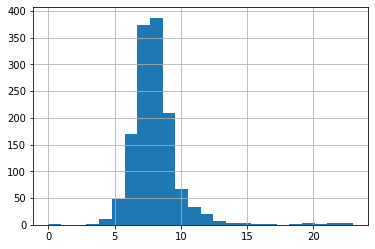

In [51]:
pd.to_datetime(ques_morning_bodyfatigue['datetime']).dt.hour.hist(bins=24)

In [52]:
ques_morning_bodyfatigue = ques_morning_bodyfatigue[['datetime', 'user_id', 'datetime_jp_before3',
       'datetime_jp_before6', 'datetime_jp_before9', 'record_type_id', 'hour',
       'nemuke_score', 'hukai_score', 'daruke_score']]

In [53]:
ques_morning_bodyfatigue.columns

Index(['datetime', 'user_id', 'datetime_jp_before3', 'datetime_jp_before6',
       'datetime_jp_before9', 'record_type_id', 'hour', 'nemuke_score',
       'hukai_score', 'daruke_score'],
      dtype='object')

In [56]:
work_env = canact_all.query('(name=="業務状況")|(name=="業務環境評価")|(name=="業務環境")')
work_env = work_env.dropna(subset=['value'])
value_unique = work_env['value'].unique()

## ロングデータからワイドへの変換

In [57]:
zero_td = dt.timedelta(days=0, hours=0, minutes=0,
                        seconds=0, milliseconds=0, microseconds=0)
work_env['start'] = pd.to_datetime(work_env['start'])
work_env['finish'] = pd.to_datetime(work_env['finish'])
for i in range(len(value_unique)):
    work_env['{}'.format(value_unique[i])] = zero_td  #timedeltaの０で埋める
    work_env.loc[work_env['value']==value_unique[i],value_unique[i]]=work_env['finish']-work_env['start']  #行動の継続時間を計算
    work_env['{}'.format(value_unique[i])] = work_env['{}'.format(value_unique[i])].dt.total_seconds()/60  #
work_env['date'] = work_env['finish'].dt.date

In [44]:
work_env_sum = work_env.groupby(['date','user_id'],as_index=False).sum()

In [45]:
# work_env.to_csv('../../datas/groupby_widedata/work_env.csv')

## work_detail(業務内容，業務の位置付け，業務の新規性，業務における立場)

In [70]:
work_detail = canact_all.query('(name=="業務内容")|(name=="業務の位置付け")|(name=="業務の新規性")|(name=="業務における立場")')
work_detail = work_detail.dropna(subset=['value'])

In [69]:
work_detail['value'].unique()

array([nan, '管理者兼作業者', '企画業務', 'ノンコア業務（自身が本来担当ではない業務）', '管理者',
       '比較的慣れており，定型化できている業務', 'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務',
       '管理業務', '作業者/参加者', '管理の業務', '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務',
       '事務業務（サポート業務、経理業務など）', '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）'],
      dtype=object)

In [73]:
value_detail_unique = work_detail['value'].unique()
zero_td = dt.timedelta(days=0, hours=0, minutes=0,
                        seconds=0, milliseconds=0, microseconds=0)
work_detail['start'] = pd.to_datetime(work_detail['start'])
work_detail['finish'] = pd.to_datetime(work_detail['finish'])
for i in range(len(value_detail_unique)):
    work_detail['{}'.format(value_detail_unique[i])] = zero_td  #timedeltaの０で埋める
    work_detail.loc[work_detail['value']==value_detail_unique[i],value_detail_unique[i]]=work_detail['finish']-work_detail['start']  #行動の継続時間を計算
    work_detail['{}'.format(value_detail_unique[i])] = work_detail['{}'.format(value_detail_unique[i])].dt.total_seconds()/60  #
work_detail['date'] = work_detail['finish'].dt.date

In [75]:
work_detail_sum = work_detail.groupby(['date','user_id'],as_index=False).sum()

In [77]:
# work_detail_sum.to_csv('../../datas/groupby_widedata/work_detail.csv')

,date,user_id,activity_type_id,record_type_id,管理者兼作業者,企画業務,ノンコア業務（自身が本来担当ではない業務）,管理者,比較的慣れており，定型化できている業務,コア業務（自身が本来担当している業務）,共同作業者,開発業務,管理業務,作業者/参加者,管理の業務,比較的新規性が高く，試行錯誤を伴う定型化できていない業務,営業業務,事務業務（サポート業務、経理業務など）,現場業務（主に肉体労働を伴うもの）,現場（主に肉体労働を伴うもの）
0,2021-01-05,56,4,602.0,0.000000,0.000000,0.0,0.00,0.016667,0.016667,0.000000,0.000000,0.000000,0.016667,0.016667,0.00,0.0,0.0,0.0,0.0
1,2021-01-05,59,108,3748.0,0.000000,0.000000,0.0,0.00,338.966667,338.966667,338.966667,0.000000,338.966667,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0
2,2021-01-05,77,90,2780.0,21.650000,245.333333,0.0,98.45,0.000000,343.783333,0.000000,0.000000,98.450000,223.683333,0.000000,129.10,0.0,0.0,0.0,0.0
3,2021-01-06,9,34,1539.0,0.000000,126.000000,144.0,105.00,126.000000,171.000000,0.000000,0.000000,189.000000,0.000000,0.000000,144.00,0.0,0.0,0.0,0.0
4,2021-01-06,60,20,618.0,0.000000,0.000000,0.0,0.00,0.000000,432.650000,0.000000,432.650000,0.000000,432.650000,0.000000,432.65,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2021-01-30,48,4,602.0,0.000000,0.000000,0.0,0.00,1183.000000,1183.000000,0.000000,0.000000,0.000000,1183.000000,0.000000,0.00,1183.0,0.0,0.0,0.0
1092,2021-01-30,72,55,1698.0,0.033333,0.000000,0.0,0.00,502.516667,502.516667,0.000000,502.516667,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0
1093,2021-01-30,73,12,24.0,0.000000,0.000000,0.0,0.00,1380.000000,1380.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,1380.0,0.0,0.0,0.0
1094,2021-01-30,82,20,618.0,0.000000,0.000000,1411.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,1411.000000,0.000000,1411.00,0.0,1411.0,0.0,0.0
